## Determination of Negative Modes

The purpose of this notebook is to determine the negative modes of the connected wormhole solution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from scipy.special import ellipkinc
import sympy

sympy.init_printing()

### Preliminaries

In [2]:
r, r_0, L = sympy.symbols("r r_0 L")

In [3]:
# spherical part of the metric
g = sympy.Function("g")(r)
dg = sympy.diff(g, r)

g_sol = r ** 2 + r_0 ** 2
dg_sol = sympy.diff(g_sol, r)

def g_func(r, r_0):
    return r ** 2 + r_0 ** 2
def dg_func(r):
    return 2 * r

In [4]:
# radial part of the metric
f = sympy.Function("f")(r)
df = sympy.diff(f, r)

f_sol = (L ** 2 + r ** 2 + 2 * r_0 ** 2) / L ** 2
df_sol = sympy.diff(f_sol, r)

def f_func(r, r_0, L):
    return (L ** 2 + r ** 2 + 2 * r_0 ** 2) / L ** 2
def df_func(r, L):
    return 2 * r / L ** 2

In [5]:
# gauge field
Phi = sympy.Function("Phi")(r)
dPhi = sympy.diff(Phi, r)
ddPhi = sympy.diff(dPhi, r)

ddPhi_sol = (8 * Phi - dPhi * df * g - dPhi * dg * f) / (2 * f * g)

In [6]:
def get_a(b):
    """Get a based on b."""
    return np.sqrt(2 * b ** 2 + 1)

def get_phi_star(b):
    """Get phi star based on b."""
    return b * np.sqrt(b ** 2 + 1) / 2

def get_ellip_m_param(a, b):
    """Get the elliptic integral parameter m based on a and b."""
    return 1 - a ** 2 / b ** 2

In [7]:
def phi_of_r(r, b, L):
    """Get gauge field."""
    a = get_a(b)
    m = get_ellip_m_param(a, b)
    phi_star = get_phi_star(b)
    phi = np.arctan2(r, L * a)
    return phi_star * np.cosh((2 / b) * ellipkinc(phi, m))

In [8]:
def dphi_of_r(r, b, L):
    """Get radial derivative of gauge field."""
    a = get_a(b)
    m = get_ellip_m_param(a, b)
    phi_star = get_phi_star(b)
    phi = np.arctan(r / (L * a))

    a_term = a ** 2 * L ** 2 + r ** 2
    b_term = b ** 2 * L ** 2 + r ** 2

    return 2 * L * phi_star * np.sinh((2 / b) * ellipkinc(phi, m)) / np.sqrt(a_term * b_term)

In [9]:
q = sympy.Function("q")(r)
dq = sympy.diff(q, r)
ddq = sympy.diff(dq, r)

K = sympy.Function("K")(r)
dK = sympy.diff(K, r)
K_sol = 6 * L ** 2 * r ** 2 / (r ** 2 - g * L ** 2 * dPhi ** 2)

V = sympy.Function("V")(r)
V_sol = (4 * K_sol / g) * ((2 * g) / (L ** 2 * f * r) * ((L ** 2 * (r - L ** 2 * Phi * dPhi) + g * (r - 2 * L ** 2 * Phi * dPhi)) / (r ** 2 - g * L ** 2 * dPhi ** 2)) - 1)

### Eigenvalue Problem

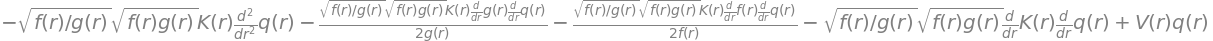

In [46]:
eigen = -sympy.sqrt(f / g) * sympy.diff(sympy.sqrt(f * g) * K * dq, r) + V * q
eigen.expand()

Simplify.

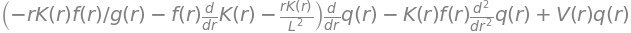

In [47]:
eigen = -r * f * K * dq / g - f * K * ddq - f * dK * dq + V * q - r * K * dq / L ** 2
eigen.collect([q, dq])

Separate the terms.

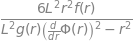

In [48]:
ddq_factor = eigen.coeff(ddq).subs({K: K_sol}).simplify()
ddq_factor

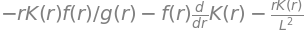

In [49]:
dq_factor = eigen.coeff(dq)
dq_factor

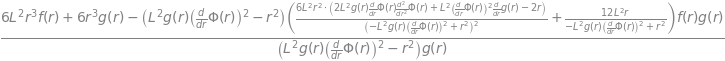

In [50]:
dq_factor = dq_factor.subs({K: K_sol}).simplify()
dq_factor

Substitute the expression for Phi".

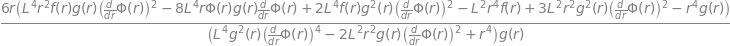

In [51]:
dq_factor = dq_factor.subs({ddPhi: ddPhi_sol}).subs({dg: dg_sol, df: df_sol}).expand().simplify()
dq_factor

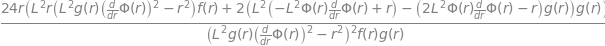

In [52]:
q_factor = eigen.coeff(q).subs({V: V_sol}).simplify()
q_factor

Make the change of variables, r = r_0 * y / (1 - y), or y = r / (r + r_0).

In [53]:
y = r / (r + r_0)
y

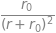

In [54]:
dy = sympy.diff(y, r).simplify()
dy

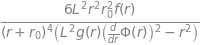

In [55]:
ddq_factor = ddq_factor * dy ** 2
ddq_factor

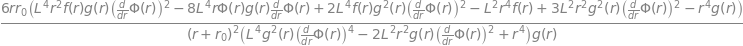

In [56]:
dq_factor = dq_factor * dy
dq_factor

#### Discretize

The idea is to tune r_0, the length of the wormhole throat, and determine the eigenvalue. Since r_0 = bL, this amounts to tuning b. Therefore, all functions should depend on b.

First, form a grid.

In [57]:
def cheb(N, x_minus, x_plus):
    def get_a_j(x, j):
        a = 1
        for k in range(len(x)):
            if k != j:
                a *= x[j] - x[k]
        return a

    x = (x_plus + x_minus) / 2 + (x_plus - x_minus) / 2 * np.cos(np.pi * np.arange(0, N + 1) / N)

    D = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        a_i = get_a_j(x, i)
        for j in range(N + 1):
            if j != i:
                # diagonal element
                D[i, i] += 1 / (x[i] - x[j])
                # off diagonal element
                a_j = get_a_j(x, j)
                D[i, j] = a_i / (a_j * (x[i] - x[j]))

    return D, x

In [121]:
y_minus = 0
y_plus = 0.99
N = 300

In [122]:
D, y_vals = cheb(N, y_minus, y_plus)
D

array([[ 6.06063973e+04, -7.36888070e+04,  1.84227068e+04, ...,
         2.02042358e+00, -2.02025741e+00,  1.01010101e+00],
       [ 1.84222017e+04, -9.21084834e+03, -1.22819168e+04, ...,
        -1.01023949e+00,  1.01015640e+00, -5.05064352e-01],
       [-4.60567670e+03,  1.22819168e+04, -2.30258580e+03, ...,
         1.01032259e+00, -1.01023949e+00,  5.05105894e-01],
       ...,
       [-5.05105894e-01,  1.01023949e+00, -1.01032259e+00, ...,
         2.30258580e+03, -1.22819168e+04,  4.60567670e+03],
       [ 5.05064352e-01, -1.01015640e+00,  1.01023949e+00, ...,
         1.22819168e+04,  9.21084834e+03, -1.84222017e+04],
       [-1.01010101e+00,  2.02025741e+00, -2.02042358e+00, ...,
        -1.84227068e+04,  7.36888070e+04, -6.06063973e+04]])

In [123]:
D2 = D @ D
D2

array([[ 2.20385675e+09, -3.50198595e+09,  1.89367165e+09, ...,
         2.44897106e+05, -2.44876965e+05,  1.22435126e+05],
       [ 1.01814186e+09, -1.45591141e+09,  5.27944705e+08, ...,
         1.86123666e+04, -1.86108356e+04,  9.30516265e+03],
       [-6.36391000e+07,  2.45130625e+08, -3.00376343e+08, ...,
        -4.65475040e+03,  4.65436736e+03, -2.32711984e+03],
       ...,
       [-2.32711984e+03,  4.65436736e+03, -4.65475040e+03, ...,
        -3.00376343e+08,  2.45130625e+08, -6.36391000e+07],
       [ 9.30516265e+03, -1.86108356e+04,  1.86123666e+04, ...,
         5.27944705e+08, -1.45591141e+09,  1.01814186e+09],
       [ 1.22435126e+05, -2.44876965e+05,  2.44897106e+05, ...,
         1.89367165e+09, -3.50198595e+09,  2.20385675e+09]])

In [124]:
L_val = 1

In [125]:
def evaluate_factors_numerically(b_val):
    """Evaluate the different factors in the differential equations for a given value of b."""
    ny = len(y_vals)

    ddq_factors_num = np.zeros((ny, ny))
    dq_factors_num = np.zeros((ny, ny))
    q_factors_num = np.zeros((ny, ny), dtype=object)

    r_0_val = b_val * L_val

    for idx, y_val in enumerate(y_vals):
        r_val = r_0_val * y_val / (1 - y_val)

        f_val = f_func(r_val, r_0_val, L_val)
        g_val = g_func(r_val, r_0_val)
        Phi_val = phi_of_r(r_val, b_val, L_val)
        dPhi_val = dphi_of_r(r_val, b_val, L_val)

        func_subs = {r: r_val, r_0: r_0_val, L: L_val, f: f_val, g: g_val, Phi: Phi_val, dPhi: dPhi_val}

        ddq_factors_num[idx, idx] = ddq_factor.subs(func_subs)
        dq_factors_num[idx, idx] = dq_factor.subs(func_subs)
        q_factors_num[idx, idx] = q_factor.subs(func_subs)

    return ddq_factors_num, dq_factors_num, q_factors_num

In [126]:
def get_A_matrix(b_val, boundary_condition='qdot'):
    """Build the A matrix of the eigenvalue problem given the value for b.

    Args:
        boundary_condition (str): Can be 'q' or 'qdot'. If 'q', then condition q(0) = 0 is used. If 'qdot', then
            q'(0) = 0

    """
    ddq_factors_num, dq_factors_num, q_factors_num = evaluate_factors_numerically(b_val)
    A = ddq_factors_num @ D2 + dq_factors_num @ D + q_factors_num

    if boundary_condition == 'qdot':
        # replace last row with q'(0) = 0
        A[-1] = D[-1]
        A = A.astype(float)
    else:
        A[-1] = 0
        A[-1][-1] = 1
        A = A.astype(float)

    return A

In [127]:
def get_B_matrix():
    """Build the B matrix."""
    B = np.identity(len(y_vals))
    B[-1] = 0
    return B

Get the eigenvalues for the general eigenvalue problem A * p = lam * B * p.

In [110]:
b_0_min = 1.251462

In [111]:
A = get_A_matrix(b_0_min)
B = get_B_matrix()
w, vr = linalg.eig(A, B)

In [112]:
A

array([[-2.59269271e+05,  4.10796063e+05, -2.21011057e+05, ...,
        -6.42715176e+01,  6.42596248e+01, -3.21278306e+01],
       [-1.20716860e+05,  1.71713180e+05, -6.14390807e+04, ...,
        -4.80549139e+00,  4.80460187e+00, -2.40215271e+00],
       [ 8.00636702e+03, -3.05447484e+04,  3.67405061e+04, ...,
         1.15441385e+00, -1.15419995e+00,  5.77064328e-01],
       ...,
       [ 4.10326721e+04, -8.20704128e+04,  8.20856213e+04, ...,
         2.35296637e+09, -1.92013909e+09,  4.98487401e+08],
       [-1.64119384e+05,  3.28259023e+05, -3.28319796e+05, ...,
        -4.13820564e+09,  1.14115252e+10, -7.98016878e+09],
       [-1.01010101e+00,  2.02032664e+00, -2.02070057e+00, ...,
        -8.18824383e+03,  3.27509550e+04, -2.69363636e+04]])

In [113]:
sorted(w)

[(-495.8873203397678+0j),
 (-242.48711789012486-467.88976426472766j),
 (-242.48711789012484+467.8897642647276j),
 (-3.104831858974393+0j),
 (8.837662590406957-28.179914940820428j),
 (8.837662590406957+28.17991494082043j),
 (44.08883386055737-56.61620803212668j),
 (44.08883386055737+56.61620803212668j),
 (102.08880459286328-85.64757455255679j),
 (102.08880459286328+85.6475745525568j),
 (183.4219668439164-114.87204331394612j),
 (183.4219668439164+114.87204331394611j),
 (287.54344587467403-144.13821432448643j),
 (287.54344587467403+144.13821432448643j),
 (292.2868005767243-543.2831815843256j),
 (292.2868005767243+543.2831815843256j),
 (414.43062245448806-173.0252459247425j),
 (414.4306224544881+173.0252459247425j),
 (560.5186323615062-202.87006730575192j),
 (560.5186323615062+202.87006730575192j),
 (700.5928689768105-245.8628274352165j),
 (700.5928689768105+245.8628274352165j),
 (819.4039871032217-230.36133146292715j),
 (819.4039871032218+230.36133146292718j),
 (997.0739580793781+193.1066

Validate the eigenvalues.

In [32]:
errors = []
for i in range(len(w)):
    errors.append(np.abs(w[1, i] * A @ vr[:, i] - w[0, i] * B @ vr[:, i]).max())
print("Max error =", max(errors))

Max error = 1.4086253941059113e-08


Plot the eigenvectors.

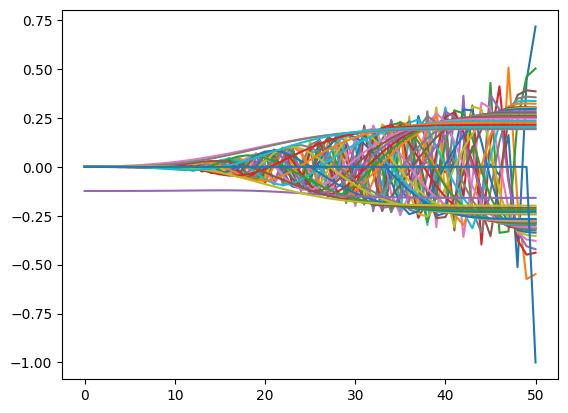

In [33]:
plt.plot(range(w.shape[1]), vr);

In [128]:
def get_eigenvalues_vectors(b_val, boundary_condition='qdot'):
    """Get the eigenvalues given the value for b."""
    A = get_A_matrix(b_val, boundary_condition=boundary_condition)
    B = get_B_matrix()

    w, v = linalg.eig(A, B)

    is_not_complex = ~np.iscomplex(w)
    w = np.real(w[is_not_complex])
    v = v[is_not_complex]

    w_argsort = np.argsort(w)
    w = w[w_argsort]
    v = v[w_argsort]

    return w, v

Get eigenvalues for different values of b for the boundary condition q'(0) = 0.

In [129]:
eigenvalues = []
eigenvectors = []

fracs = [0.8, 0.9, 0.95, 1, 1.05, 1.1] #[0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1]

for frac in fracs:
    w, v = get_eigenvalues_vectors(frac * b_0_min)
    eigenvalues.append(w)
    eigenvectors.append(v)

In [99]:
i = 17
fracs[i], eigenvalues[i]

(1.07,
 array([6.75094686e-08, 1.19535362e+01, 1.38926102e+01, 1.86226229e+01,
        2.71941396e+01, 4.02455941e+01, 5.82085246e+01, 8.15032679e+01,
        1.10572853e+02, 1.45875501e+02, 1.87886561e+02, 2.37107506e+02,
        2.94148714e+02, 3.59807850e+02, 4.35480249e+02, 5.22990117e+02,
        6.25409850e+02, 7.45315618e+02, 8.87707182e+02, 1.05510367e+03,
        1.25672718e+03, 1.49463883e+03, 1.78868792e+03, 2.13845163e+03,
        2.58973414e+03, 3.13163138e+03, 3.86494816e+03, 4.74618740e+03,
        5.97512595e+03, 7.43983316e+03, 9.50898077e+03, 1.19537430e+04,
        1.54290465e+04, 1.95141465e+04, 2.53603453e+04, 3.22286129e+04,
        4.21743487e+04, 5.39187010e+04, 7.12861578e+04, 9.20592536e+04,
        1.23885256e+05, 1.62899382e+05, 2.26270816e+05, 3.07499382e+05,
        4.53245082e+05, 6.56478877e+05, 1.09621031e+06, 1.83206401e+06,
        4.33546393e+06, 1.17501359e+07,            inf]))

In [100]:
eg = [eigenvalues[i][0] for i in range(len(fracs))]
eg

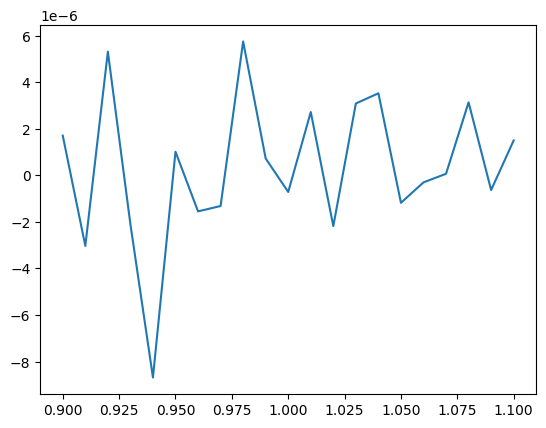

In [102]:
plt.plot(fracs, eg)

In [136]:
eigenvalues[6]

IndexError: list index out of range

In [73]:
eigenvalues[2]

array([7.04949758e-09, 1.19916252e+01, 1.34691313e+01, 1.62736657e+01,
       2.14300955e+01, 2.95606188e+01, 4.12487518e+01, 5.71186168e+01,
       7.78823583e+01, 1.04328290e+02, 1.37389177e+02, 1.78060269e+02,
       2.27627455e+02, 2.87349685e+02, 3.59133292e+02, 4.44548141e+02,
       5.46677983e+02, 6.67400310e+02, 8.12220246e+02, 9.83139582e+02,
       1.19108289e+03, 1.43736812e+03, 1.74609529e+03, 2.11486751e+03,
       2.60002734e+03, 3.18469862e+03, 3.99276073e+03, 4.96542993e+03,
       6.34743878e+03, 7.99589873e+03, 1.03608281e+04, 1.31575495e+04,
       1.71817353e+04, 2.19170234e+04, 2.87549378e+04, 3.67967031e+04,
       4.85138452e+04, 6.23619855e+04, 8.29188168e+04, 1.07521546e+05,
       1.45291262e+05, 1.91607206e+05, 2.66902133e+05, 3.63428272e+05,
       5.36656460e+05, 7.78225851e+05, 1.30088541e+06, 2.17553639e+06,
       5.15097692e+06, 1.39639204e+07,            inf])

In [74]:
eigenvalues[3]

array([5.19107316e-09, 1.19916202e+01, 1.35914890e+01, 1.64276744e+01,
       2.16024805e+01, 2.96668086e+01, 4.12043872e+01, 5.68273280e+01,
       7.72247587e+01, 1.03158195e+02, 1.35523625e+02, 1.75279129e+02,
       2.23645895e+02, 2.81830565e+02, 3.51612823e+02, 4.34495877e+02,
       5.33297393e+02, 6.49831526e+02, 7.89002240e+02, 9.52819253e+02,
       1.15073379e+03, 1.38438083e+03, 1.67397279e+03, 2.01858339e+03,
       2.46457956e+03, 3.00051220e+03, 3.72870519e+03, 4.60501324e+03,
       5.83326728e+03, 7.29978474e+03, 9.38210436e+03, 1.18468322e+04,
       1.53662297e+04, 1.95098336e+04, 2.54609731e+04, 3.24621369e+04,
       4.26271643e+04, 5.46438492e+04, 7.24463266e+04, 9.37580321e+04,
       1.26446584e+05, 1.66543106e+05, 2.31714852e+05, 3.15286556e+05,
       4.65283446e+05, 6.74499880e+05, 1.12722554e+06, 1.88492211e+06,
       4.46265646e+06, 1.20977928e+07,            inf])

In [75]:
eigenvalues[4]

array([3.18736774e-09, 1.19916214e+01, 1.36347160e+01, 1.64912175e+01,
       2.16675174e+01, 2.96701239e+01, 4.10750573e+01, 5.64844872e+01,
       7.65703901e+01, 1.02073819e+02, 1.33862061e+02, 1.72863295e+02,
       2.20247398e+02, 2.77177811e+02, 3.45335674e+02, 4.26167910e+02,
       5.22291231e+02, 6.35460999e+02, 7.70140660e+02, 9.28319936e+02,
       1.11840264e+03, 1.34218847e+03, 1.61719938e+03, 1.94337963e+03,
       2.36021773e+03, 2.85964927e+03, 3.52897735e+03, 4.33379134e+03,
       5.44942276e+03, 6.78224068e+03, 8.65924115e+03, 1.08825052e+04,
       1.40381160e+04, 1.77552100e+04, 2.30714687e+04, 2.93276888e+04,
       3.83867934e+04, 4.90986987e+04, 6.49445457e+04, 8.39184440e+04,
       1.13002737e+05, 1.48686988e+05, 2.06680217e+05, 2.81063501e+05,
       4.14581867e+05, 6.00844424e+05, 1.00394555e+06, 1.67864232e+06,
       3.97411394e+06, 1.07733085e+07,            inf])

Plot the eigenvalues.

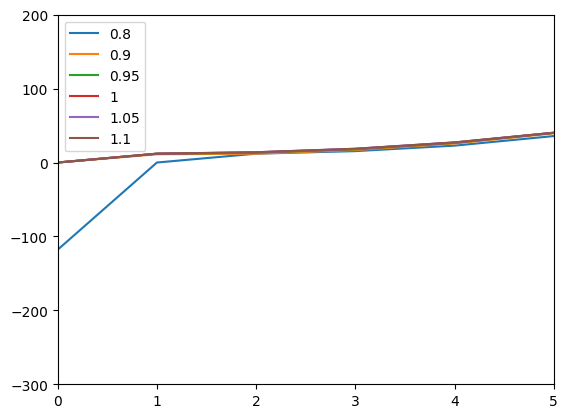

In [37]:
for i in range(len(eigenvalues)):
    plt.plot(range(len(eigenvalues[i])), eigenvalues[i], label=fracs[i])

plt.legend()
plt.xlim([0, 5])
plt.ylim([-300, 200]);

Show that there are no negative modes for the boundary condition q(0) = 0.

In [97]:
eigenvalues = []
eigenvectors = []

fracs = [0.8, 0.9, 0.95, 1, 1.05, 1.1]

for frac in fracs:
    w, v = get_eigenvalues_vectors(frac * b_0_min, boundary_condition='q')
    eigenvalues.append(w)
    eigenvectors.append(v)

In [98]:
for i in range(len(eigenvalues)):
    print(np.any(eigenvalues[i] < 0))

False
False
False
False
False
False


##### Verify Chebyshev differentiation

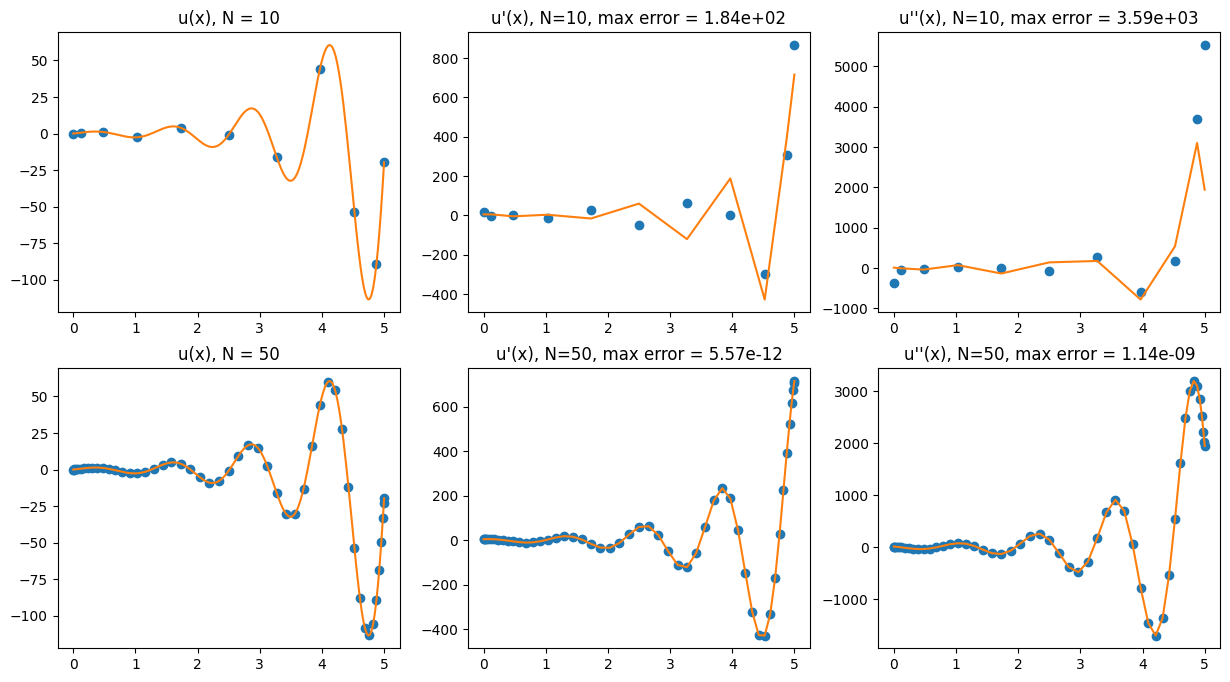

In [40]:
x_min = 0
x_max = 5

xx = np.linspace(x_min, x_max, 200, True)
uu = np.exp(xx) * np.sin(5.0 * xx)

c = 1; plt.figure(figsize=(15, 8))

for N in [10, 50]:
    D, x = cheb(N, x_min, x_max)
    u = np.exp(x) * np.sin(5.0 * x)

    plt.subplot(2, 3, c); c += 1
    plt.plot(x, u, 'o', xx, uu)
    plt.title(f'u(x), N = {N}')

    deriv_est = np.dot(D, u)
    deriv_true = np.exp(x) * (np.sin(5.0 * x) + 5.0 * np.cos(5.0 * x))
    max_error_deriv = np.abs(max(deriv_est - deriv_true))

    plt.subplot(2, 3, c); c += 1
    plt.plot(x, deriv_est, 'o', x, deriv_true)
    plt.title(f'u\'(x), N={N}, max error = {max_error_deriv:.2e}')

    dderiv_est = np.dot(D @ D, u)
    dderiv_true = np.exp(x) * (-24.0 * np.sin(5.0 * x) + 10.0 * np.cos(5.0 * x))
    max_error_dderiv = np.abs(max(dderiv_est - dderiv_true))

    plt.subplot(2, 3, c); c += 1
    plt.plot(x, dderiv_est, 'o', x, dderiv_true)
    plt.title(f'u\'\'(x), N={N}, max error = {max_error_dderiv:.2e}')

/Users/james.chryssanthacopoulos/src/wormholes/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/james.chryssanthacopoulos/src/wormholes/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/james.chryssanthacopoulos/src/wormholes/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/james.chryssanthacopoulos/src/wormholes/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/james.chryssanthacopoulos/src/wormholes/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: RankWarni

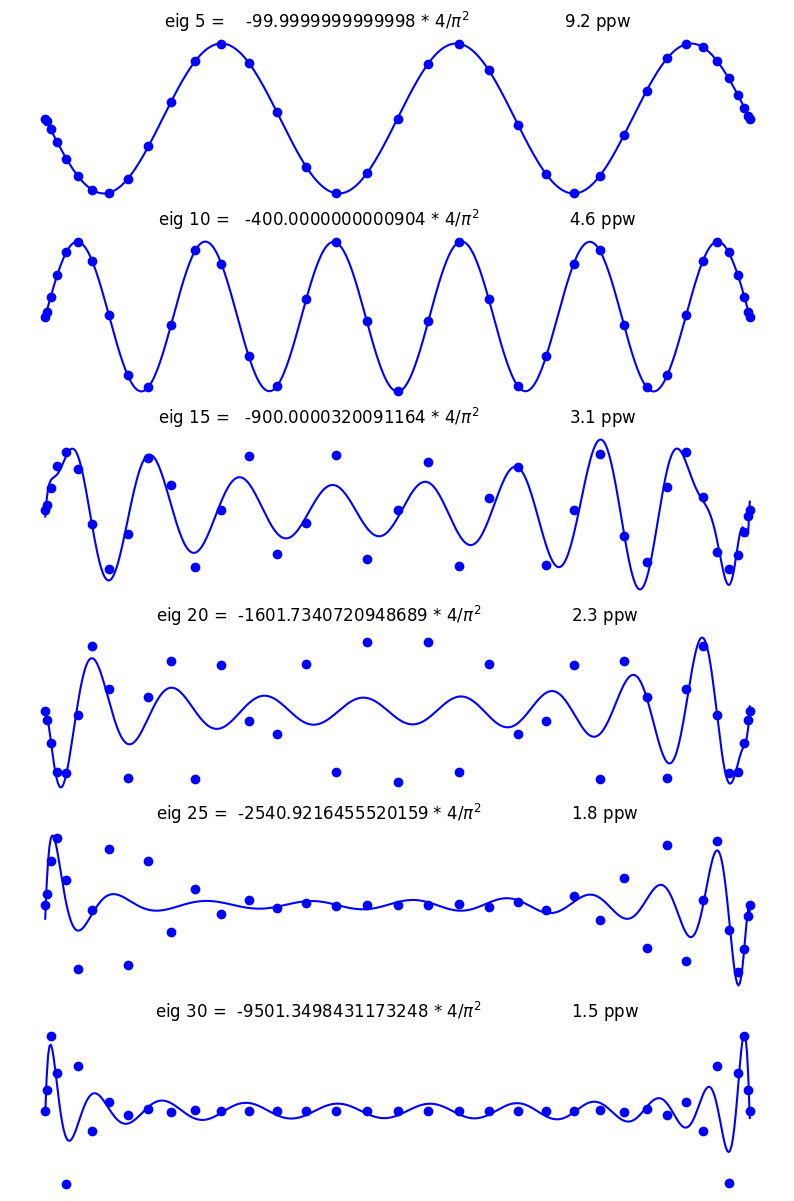

In [41]:
N = 36

x_min = 0
x_max = 1

D, x = cheb(N, x_min, x_max)
D2 = np.dot(D, D)
D2 = D2[1:N, 1:N]

lam, V = linalg.eig(D2)   
ii = np.argsort(-lam)
lam = np.real(lam[ii])
V = V[:, ii]

fig = plt.figure(figsize=(10, 15))
for j in range(5, 35, 5): 
    lv = np.shape(V)[0] + 2
    u = np.zeros(lv)
    u[1:lv - 1] = V[:, int(j)]  

    plt.subplot(6, 1, j//5)
    plt.plot(x, u, 'bo')

    xx = np.linspace(x_min, x_max, 501)
    uu = np.polyval(np.polyfit(x, u, N), xx)    # interpolate grid data
    s = 'eig %d = %20.13f * 4/$\pi^2$' % (j, lam[j-1]*4/np.pi**2)
    s = s + '\t\t %4.1f ppw' % (4*N/(np.pi*j))

    plt.title(s)
    plt.plot(xx,uu,'b')
    plt.axis('off')